In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop


In [ ]:

data = pd.read_csv('/content/features_6.csv')
X = data.iloc[: ,:-2].values
y = data['labels'].values


maping = {'angry': 5,
 'calm': 3,
 'disgust': 2,
 'fear': 0,
 'happy': 1,
 'neutral': 7,
 'sad': 4,
 'surprise': 6}

train_y = []
for i in y:
    train_y.append(maping[i])

train_y = np.array(train_y)

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, train_y, test_size=0.2, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

labels_train_y = to_categorical(y_train)
labels_test_y = to_categorical(y_test)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (163) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(x_train.shape, x_test.shape)

(13568, 162) (3392, 162)


## CNN model

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 162, 256)          2304      
_________________________________________________________________
activation_30 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 162, 256)          1024      
_________________________________________________________________
activation_31 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)         

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(np.expand_dims(x_train,-1), 
                        labels_train_y,
                        batch_size=16, 
                        epochs=200, 
                        validation_split=0.2)

Epoch 1/200
679/679 [==============================] - 9s 10ms/step - loss: 2.0462 - accuracy: 0.1744 - val_loss: 1.9095 - val_accuracy: 0.3475
Epoch 2/200
679/679 [==============================] - 6s 9ms/step - loss: 1.8169 - accuracy: 0.3256 - val_loss: 1.6648 - val_accuracy: 0.4683
Epoch 3/200
679/679 [==============================] - 6s 9ms/step - loss: 1.5721 - accuracy: 0.4490 - val_loss: 1.5502 - val_accuracy: 0.4727
Epoch 4/200
679/679 [==============================] - 6s 9ms/step - loss: 1.3955 - accuracy: 0.5117 - val_loss: 1.3769 - val_accuracy: 0.5538
Epoch 5/200
679/679 [==============================] - 6s 9ms/step - loss: 1.2809 - accuracy: 0.5609 - val_loss: 1.2628 - val_accuracy: 0.6249
Epoch 6/200
679/679 [==============================] - 6s 9ms/step - loss: 1.1800 - accuracy: 0.5894 - val_loss: 1.1884 - val_accuracy: 0.6091
Epoch 7/200
679/679 [==============================] - 6s 9ms/step - loss: 1.0782 - accuracy: 0.6300 - val_loss: 1.1381 - val_accuracy: 0.634

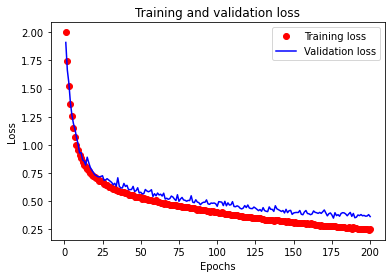

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

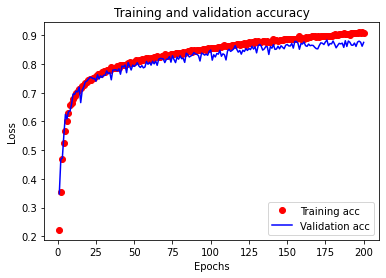

In [ ]:
plt.clf()                                                

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
preds = model.predict(np.expand_dims(x_test,-1)).argmax(axis=1)
acc = (y_test == preds).sum()/preds.size
print("test accuracy is   ", acc)

test accuracy is    0.8806014150943396


## LSTM model

In [ ]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(550, return_sequences=False, input_shape=(x_train.shape[1], 1)))
    # model.add(LSTM(1280, return_sequences=False, input_shape=(128, 1)))

    model.add(Dense(64))
    # model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
### train using LSTM model
model_lstm = create_model_LSTM()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 550)               1214400   
_________________________________________________________________
dense_36 (Dense)             (None, 64)                35264     
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
activation_60 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32)                128       
_________________________________________________________________
activation_61 (Activation)   (None, 32)              

In [ ]:
history = model_lstm.fit(np.expand_dims(x_train,-1), 
                      labels_train_y, validation_split=0.15, 
                         epochs=200, batch_size=32)

Epoch 1/200
361/361 [==============================] - 12s 29ms/step - loss: 1.9285 - accuracy: 0.2201 - val_loss: 57.8869 - val_accuracy: 0.1483
Epoch 2/200
361/361 [==============================] - 10s 28ms/step - loss: 1.7120 - accuracy: 0.3279 - val_loss: 17.1560 - val_accuracy: 0.1321
Epoch 3/200
361/361 [==============================] - 10s 29ms/step - loss: 1.4732 - accuracy: 0.4553 - val_loss: 36.4859 - val_accuracy: 0.1321
Epoch 4/200
361/361 [==============================] - 10s 29ms/step - loss: 1.3142 - accuracy: 0.5045 - val_loss: 20.9051 - val_accuracy: 0.1331
Epoch 5/200
361/361 [==============================] - 10s 29ms/step - loss: 1.2165 - accuracy: 0.5345 - val_loss: 8.8790 - val_accuracy: 0.1483
Epoch 6/200
361/361 [==============================] - 10s 29ms/step - loss: 1.1314 - accuracy: 0.5721 - val_loss: 9.7194 - val_accuracy: 0.1498
Epoch 7/200
361/361 [==============================] - 10s 28ms/step - loss: 1.0478 - accuracy: 0.6008 - val_loss: 7.9843 - va

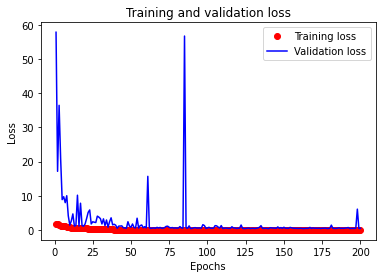

In [ ]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

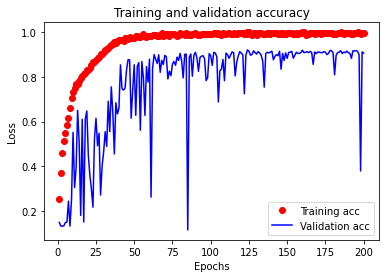

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
preds = model_lstm.predict(np.expand_dims(x_test,-1)).argmax(axis=1)
acc = (y_test == preds).sum()/preds.size
print("test accuracy is   ", acc)

test accuracy is    0.9162735849056604


In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
# Define the BLSTM model
def create_model_BLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(390, return_sequences=False), input_shape=(x_train.shape[1], 1)))
    # model.add(LSTM(1280, return_sequences=False, input_shape=(128, 1)))

    model.add(Dense(64))
    # model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
model_blstm = create_model_BLSTM()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 780)               1223040   
_________________________________________________________________
dense_72 (Dense)             (None, 64)                49984     
_________________________________________________________________
batch_normalization_45 (Batc (None, 64)                256       
_________________________________________________________________
activation_96 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_46 (Batc (None, 32)                128       
_________________________________________________________________
activation_97 (Activation)   (None, 32)              

In [ ]:
history = model_blstm.fit(np.expand_dims(x_train,-1), 
                      labels_train_y, validation_split=0.15, 
                         epochs=200, batch_size=32)

Epoch 1/200
361/361 [==============================] - 16s 37ms/step - loss: 1.5204 - accuracy: 0.4425 - val_loss: 2.5058 - val_accuracy: 0.2323
Epoch 2/200
361/361 [==============================] - 13s 35ms/step - loss: 0.9077 - accuracy: 0.6715 - val_loss: 1.7233 - val_accuracy: 0.4199
Epoch 3/200
361/361 [==============================] - 13s 36ms/step - loss: 0.7791 - accuracy: 0.7197 - val_loss: 1.8448 - val_accuracy: 0.4583
Epoch 4/200
361/361 [==============================] - 13s 36ms/step - loss: 0.6860 - accuracy: 0.7507 - val_loss: 10.5067 - val_accuracy: 0.1542
Epoch 5/200
361/361 [==============================] - 13s 36ms/step - loss: 0.6456 - accuracy: 0.7611 - val_loss: 1.7536 - val_accuracy: 0.5123
Epoch 6/200
361/361 [==============================] - 13s 35ms/step - loss: 0.6002 - accuracy: 0.7773 - val_loss: 5.2824 - val_accuracy: 0.3256
Epoch 7/200
361/361 [==============================] - 13s 35ms/step - loss: 0.5579 - accuracy: 0.7944 - val_loss: 2.7336 - val_a

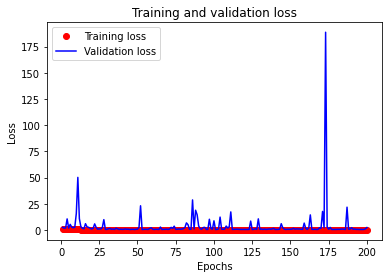

In [ ]:
### loss plots using BLSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

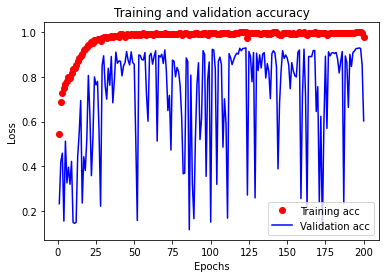

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [104]:
preds = model_blstm.predict(np.expand_dims(x_test,-1)).argmax(axis=1)
acc = (y_test == preds).sum()/preds.size
print("test accuracy is   ", acc)

test accuracy is    0.9109669811320755


In [ ]:
# Define the BLSTM model
def create_model_StackedLSTM():
    model = Sequential()
    model.add(LSTM(300, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(300, return_sequences=False, input_shape=(300, 1)))

    model.add(Dense(64))
    # model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
model_slstm = create_model_StackedLSTM()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 162, 300)          362400    
_________________________________________________________________
lstm_44 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_78 (Dense)             (None, 64)                19264     
_________________________________________________________________
batch_normalization_49 (Batc (None, 64)                256       
_________________________________________________________________
activation_102 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_50 (Batc (None, 32)              

In [ ]:
history = model_slstm.fit(np.expand_dims(x_train,-1), 
                      labels_train_y, validation_split=0.15, 
                         epochs=200, batch_size=32)

Epoch 1/200
361/361 [==============================] - 14s 32ms/step - loss: 2.0022 - accuracy: 0.1972 - val_loss: 4.6024 - val_accuracy: 0.1149
Epoch 2/200
361/361 [==============================] - 11s 30ms/step - loss: 1.7076 - accuracy: 0.3215 - val_loss: 26.6467 - val_accuracy: 0.1321
Epoch 3/200
361/361 [==============================] - 11s 31ms/step - loss: 1.5166 - accuracy: 0.4144 - val_loss: 21.5588 - val_accuracy: 0.1316
Epoch 4/200
361/361 [==============================] - 11s 30ms/step - loss: 1.4237 - accuracy: 0.4482 - val_loss: 12.2545 - val_accuracy: 0.1390
Epoch 5/200
361/361 [==============================] - 11s 30ms/step - loss: 1.1820 - accuracy: 0.5489 - val_loss: 18.0113 - val_accuracy: 0.1326
Epoch 6/200
361/361 [==============================] - 11s 30ms/step - loss: 1.0139 - accuracy: 0.6296 - val_loss: 15.7950 - val_accuracy: 0.2171
Epoch 7/200
361/361 [==============================] - 11s 30ms/step - loss: 0.8362 - accuracy: 0.6981 - val_loss: 9.3589 - v

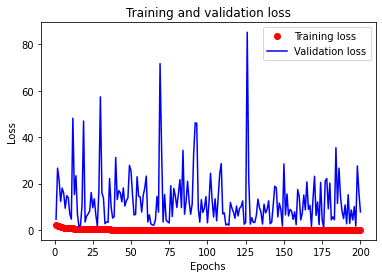

In [102]:
### loss plots using BLSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

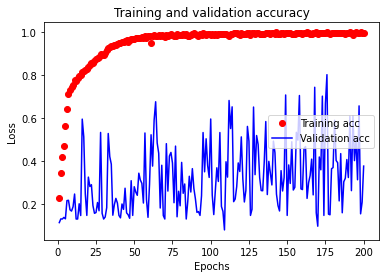

In [103]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [105]:
preds = model_slstm.predict(np.expand_dims(x_test,-1)).argmax(axis=1)
acc = (y_test == preds).sum()/preds.size
print("test accuracy is   ", acc)

test accuracy is    0.36880896226415094


In [114]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score

In [107]:
clf = LGBMClassifier(boosting_type='gbdt', objective='multiclass',
                     learning_rate=0.42352561266844885,
                     max_depth= 70,
                     n_estimators=80)

In [110]:
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
acc = (y_test == preds).sum()/preds.size
print("test accuracy is   ", acc)

test accuracy is    0.9454599056603774


In [115]:
random_state = 22
num_folds=5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
def gb_mse_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']), 
            'boosting_type': params['boosting_type'], 
            'objective': params['objective'], }
    
    clf = LGBMClassifier(**params)
    
    score = -cross_val_score(clf, X, y, scoring='accuracy', cv=cv).mean()

    return score

In [116]:
n_iter = 10
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 20, 200, 40),
       'max_depth' : hp.quniform('max_depth', 10, 100, 10),
       'learning_rate': hp.loguniform('learning_rate', -5, 0),
       'boosting_type': 'gbdt', #GradientBoostingDecisionTree
        'objective': 'multiclass', #Multi-class target feature
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

100%|██████████| 10/10 [17:31<00:00, 105.12s/it, best loss: -0.9450919872955375]


In [118]:
clf = LGBMClassifier(boosting_type='gbdt', objective='multiclass',
                     learning_rate=best['learning_rate'],
                     max_depth= int(best['max_depth']),
                     n_estimators=int(best['n_estimators']))

In [119]:
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print('model accuracy is {}, and the best parameters are {} '
      .format((pred == y_test).sum()/y_test.size, best))

model accuracy is 0.9516509433962265, and the best parameters are {'learning_rate': 0.42352561266844885, 'max_depth': 70.0, 'n_estimators': 160.0} 
